In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D
plt.style.use('dark_background')


Using TensorFlow backend.


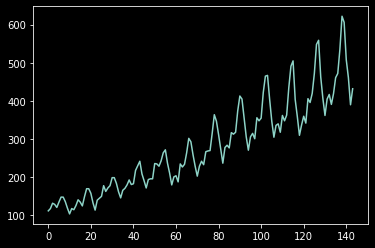

In [2]:
df = read_csv('data/AirPassengers.csv', usecols=[1])
plt.plot(df)


In [3]:
dataset = df.values
dataset = dataset.astype('float32')

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size

train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

train


array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984557],
       [0.08494207],
       [0.08494207],
       [0.06177607],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123553],
       [0.04247104],
       [0.07142857],
       [0.05984557],
       [0.04054055],
       [0.08687258],
       [0.12741312],
       [0.12741312],
       [0.10424709],
       [0.05598456],
       [0.01930502],
       [0.06949806],
       [0.07915059],
       [0.08880308],
       [0.14285713],
       [0.11389962],
       [0.13127413],
       [0.14285713],
       [0.18339768],
       [0.18339768],
       [0.15444016],
       [0.11196911],
       [0.08108109],
       [0.1196911 ],
       [0.12934363],
       [0.14671814],
       [0.17181468],
       [0.14864865],
       [0.15250966],
       [0.22007722],
       [0.24324325],
       [0.26640925],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

In [6]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)


In [7]:
seq_size = 10
#can be larger for larger datasets, number of previous values the forecast is predicted using

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

In [8]:
print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (89, 10)
Shape of test set: (33, 10)


In [16]:
trainX = trainX.reshape((trainX.shape[0], 1,seq_size))
testX = testX.reshape((testX.shape[0], 1, seq_size))

In [17]:
print('Single LSTM with hidden Dense...')
model = Sequential()
model.add(LSTM(64, input_shape=(None, seq_size)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
                        verbose=1, mode='auto', restore_best_weights=True)
model.summary()

Single LSTM with hidden Dense...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                19200     
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)

Train on 89 samples, validate on 33 samples
Epoch 1/100
 - 3s - loss: 0.0719 - val_loss: 0.3208
Epoch 2/100
 - 0s - loss: 0.0433 - val_loss: 0.2104
Epoch 3/100
 - 0s - loss: 0.0232 - val_loss: 0.1271
Epoch 4/100
 - 0s - loss: 0.0119 - val_loss: 0.0687
Epoch 5/100
 - 0s - loss: 0.0075 - val_loss: 0.0362
Epoch 6/100
 - 0s - loss: 0.0076 - val_loss: 0.0247
Epoch 7/100
 - 0s - loss: 0.0099 - val_loss: 0.0224
Epoch 8/100
 - 0s - loss: 0.0105 - val_loss: 0.0226
Epoch 9/100
 - 0s - loss: 0.0092 - val_loss: 0.0250
Epoch 10/100
 - 0s - loss: 0.0072 - val_loss: 0.0306
Epoch 11/100
 - 0s - loss: 0.0065 - val_loss: 0.0390
Epoch 12/100
 - 0s - loss: 0.0060 - val_loss: 0.0453
Epoch 13/100
 - 0s - loss: 0.0062 - val_loss: 0.0474
Epoch 14/100
 - 0s - loss: 0.0062 - val_loss: 0.0452
Epoch 15/100
 - 0s - loss: 0.0059 - val_loss: 0.0404
Epoch 16/100
 - 0s - loss: 0.0056 - val_loss: 0.0340
Epoch 17/100
 - 0s - loss: 0.0051 - val_loss: 0.0289
Epoch 18/100
 - 0s - loss: 0.0050 - val_loss: 0.0249
Epoch 19/10

In [19]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [20]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [21]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 20.59 RMSE


In [22]:
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Test Score: 42.60 RMSE


In [23]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict


In [24]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

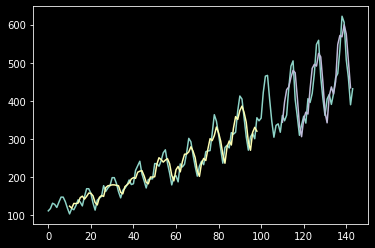

In [26]:
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [1]:
trainPredictPlot

NameError: name 'trainPredictPlot' is not defined